# Bell State Tomography via Parametric Compilation

This notebook walks through how to run **Bell state tomography** on a noisy QVM, using _parametric compilation_ and pyQuil's `Experiment` framework. This notebook is copied partially from the [rigetti/qcs-paper](https://github.com/rigetti/qcs-paper) repository, where it was used to produce **Figure A2** from [_A quantum-classical cloud platform optimized for variational hybrid algorithms_](https://scirate.com/arxiv/2001.04449).

In [1]:
import itertools
from typing import Generator, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
from scipy.linalg import pinv

import pyquil.simulation.matrices as psm
from forest.benchmarking.distance_measures import fidelity
from forest.benchmarking.operator_tools.superoperator_transformations import unvec, vec
from forest.benchmarking.utils import all_traceless_pauli_terms
from pyquil import get_qc, Program
from pyquil.experiment import (
    Experiment, ExperimentResult, ExperimentSetting, correct_experiment_result, zeros_state
)
from pyquil.gates import CNOT, H, RESET
from pyquil.paulis import PauliTerm
from pyquil.simulation.tools import lifted_pauli

/Users/peter/.pyenv/versions/3.6.3/envs/forest-tutorials/lib/python3.6/site-packages/pyquil/gate_matrices.py:24: FutureWarning: The code in pyquil.gate_matrices has been moved to pyquil.simulation.matrices, please update your import statements.
  FutureWarning,


## Simulate the Data on a Noisy QVM

In [2]:
qubits = (0, 1)
shots = 500
qc = get_qc("2q-noisy-qvm")

### Define Bell state tomography `Experiment`

In [3]:
p = Program()
p += RESET()
p += H(qubits[0])
p += CNOT(qubits[0], qubits[1])
p.wrap_in_numshots_loop(shots)
print(p)

RESET
H 0
CNOT 0 1



In [4]:
def state_tomo_settings(qubits: List[int]) -> Generator[ExperimentSetting, None, None]:
    """
    Adapted from forest.benchmarking.tomography._state_tomo_settings,
    to use pyquil.experiment.ExperimentSetting objects instead.
    """
    list_of_terms = all_traceless_pauli_terms(qubits)
    for obs in all_traceless_pauli_terms(qubits):
        yield ExperimentSetting(
            in_state=zeros_state(qubits),
            out_operator=obs,
        )

In [5]:
state_tomography_settings = list(state_tomo_settings(qubits))
state_tomography_settings

[ExperimentSetting[Z0_0 * Z0_1→(1+0j)*X1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Y1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Z1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*X0],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*X0X1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*X0Y1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*X0Z1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Y0],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Y0X1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Y0Y1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Y0Z1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Z0],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Z0X1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Z0Y1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Z0Z1]]

In [6]:
bell_state_tomography = Experiment(settings=state_tomography_settings, program=p)
bell_state_tomography

shots: 500
active reset: enabled
symmetrization: -1 (exhaustive)
calibration: 1 (plus_eigenstate)
program:
   H 0
   CNOT 0 1
settings:
   0: Z0_0 * Z0_1→(1+0j)*X1
   1: Z0_0 * Z0_1→(1+0j)*Y1
   2: Z0_0 * Z0_1→(1+0j)*Z1
   3: Z0_0 * Z0_1→(1+0j)*X0
   4: Z0_0 * Z0_1→(1+0j)*X0X1
   5: Z0_0 * Z0_1→(1+0j)*X0Y1
   6: Z0_0 * Z0_1→(1+0j)*X0Z1
   7: Z0_0 * Z0_1→(1+0j)*Y0
   8: Z0_0 * Z0_1→(1+0j)*Y0X1
   9: Z0_0 * Z0_1→(1+0j)*Y0Y1
   10: Z0_0 * Z0_1→(1+0j)*Y0Z1
   11: Z0_0 * Z0_1→(1+0j)*Z0
   12: Z0_0 * Z0_1→(1+0j)*Z0X1
   13: Z0_0 * Z0_1→(1+0j)*Z0Y1
   14: Z0_0 * Z0_1→(1+0j)*Z0Z1

### Collect data using readout symmetrization

In [7]:
%%time
results = qc.experiment(bell_state_tomography)
results

CPU times: user 1.8 s, sys: 11.1 ms, total: 1.81 s
Wall time: 3.61 s


[ExperimentResult[Z0_0 * Z0_1→(1+0j)*X1: 0.004 +- 0.03163834674860532],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y1: -0.038 +- 0.03161574853701167],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Z1: 0.016 +- 0.03163454985841817],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0: -0.006 +- 0.03163803035849364],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0X1: 0.759 +- 0.014562470009115317],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0Y1: -0.003 +- 0.02236617139367857],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0Z1: 0.028 +- 0.022357502744369335],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0: -0.018 +- 0.0316334739900106],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0X1: 0.024 +- 0.022359829627939816],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0Y1: -0.749 +- 0.014819220784249288],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0Z1: -0.031 +- 0.022355522465206355],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Z0: 0.024 +- 0.03162948662916338],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Z0X1: 0.015 +- 0.022363755694971985],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Z0

### Perform readout calibration on all observables required for 2Q state tomography

In [8]:
%%time
calibrations = qc.calibrate(bell_state_tomography)
calibrations

CPU times: user 1.76 s, sys: 10.4 ms, total: 1.77 s
Wall time: 3.64 s


[ExperimentResult[X0_1→(1+0j)*X1: 0.876 +- 0.015259647992560535],
 ExperimentResult[Y0_1→(1+0j)*Y1: 0.866 +- 0.01582069196635515],
 ExperimentResult[Z0_1→(1+0j)*Z1: 0.882 +- 0.014909671300813386],
 ExperimentResult[X0_0→(1+0j)*X0: 0.864 +- 0.015929775822583245],
 ExperimentResult[X0_0 * X0_1→(1+0j)*X0X1: 0.768 +- 0.01432447539345329],
 ExperimentResult[X0_0 * Y0_1→(1+0j)*X0Y1: 0.764 +- 0.014431082012934165],
 ExperimentResult[X0_0 * Z0_1→(1+0j)*X0Z1: 0.77 +- 0.01427066312099604],
 ExperimentResult[Y0_0→(1+0j)*Y0: 0.884 +- 0.014790630911585981],
 ExperimentResult[Y0_0 * X0_1→(1+0j)*Y0X1: 0.759 +- 0.014562470009115317],
 ExperimentResult[Y0_0 * Y0_1→(1+0j)*Y0Y1: 0.783 +- 0.013912306643330895],
 ExperimentResult[Y0_0 * Z0_1→(1+0j)*Y0Z1: 0.787 +- 0.013798938558913735],
 ExperimentResult[Z0_0→(1+0j)*Z0: 0.9 +- 0.013790945949795835],
 ExperimentResult[Z0_0 * X0_1→(1+0j)*Z0X1: 0.752 +- 0.014743021343644913],
 ExperimentResult[Z0_0 * Y0_1→(1+0j)*Z0Y1: 0.785 +- 0.013855810757435775],
 Experimen

### Correct for noisy readout using calibration results

In [9]:
results_corrected = []
for r, c in zip(results, calibrations):
    results_corrected.append(correct_experiment_result(r, c))
results_corrected

[ExperimentResult[Z0_0 * Z0_1→(1+0j)*X1: 0.0045662100456621 +- 0.036116921777475025],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y1: -0.04387990762124711 +- 0.03651659268669426],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Z1: 0.018140589569160998 +- 0.03586814747777249],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0: -0.006944444444444445 +- 0.03661831453380543],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0X1: 0.98828125 +- 0.026444641002639036],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0Y1: -0.003926701570680628 +- 0.02927518740611426],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0Z1: 0.03636363636363636 +- 0.02904353809603714],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0: -0.02036199095022624 +- 0.035786094555706645],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0X1: 0.03162055335968379 +- 0.02946583737592669],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0Y1: -0.9565772669220944 +- 0.025437759579199533],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0Z1: -0.03939008894536213 +- 0.028414395414503135],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Z0

### Build ideal density matrix for Bell state $|00\rangle + |11\rangle$

In [10]:
def build_rho_true() -> np.ndarray:
    """
    Generate the density matrix for state |00> + |11>.
    """
    psi00 = np.array([[1], [0], [0], [0]])
    bell00 = psm.CNOT @ np.kron(psm.H, psm.I) @ psi00
    return np.outer(bell00, bell00.T.conj())

rho_true = build_rho_true()
rho_true

array([[0.5, 0. , 0. , 0.5],
       [0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0.5]])

### Estimate density matrix from noisy QVM data using the linear inversion method

In [11]:
def linear_inv_state_estimate(results: List[ExperimentResult], qubits: List[int]) -> np.ndarray:
    """
    Adapted from forest.benchmarking.tomography.linear_inv_state_estimate,
    to use pyquil.experiment.ExperimentResult objects instead.
    """
    measurement_matrix = np.vstack([
        vec(lifted_pauli(result.setting.out_operator, qubits=qubits)).T.conj() for result in results])
    expectations = np.array([result.expectation for result in results])
    rho = pinv(measurement_matrix) @ expectations
    dim = 2**len(qubits)
    return unvec(rho) + np.eye(dim) / dim

rho_simulated = linear_inv_state_estimate(results_corrected, [0,1])
np.round(rho_simulated, 3)

array([[ 0.503+0.j   ,  0.007+0.015j,  0.006+0.011j,  0.486-0.007j],
       [ 0.007-0.015j,  0.007-0.j   ,  0.008+0.009j, -0.004+0.011j],
       [ 0.006-0.011j,  0.008-0.009j,  0.011-0.j   , -0.011-0.005j],
       [ 0.486+0.007j, -0.004-0.011j, -0.011+0.005j,  0.48 +0.j   ]])

### Plot the simulated data

In [12]:
DARK_TEAL = "#47717d"
GOLD = "#f8ba2b"
LIGHT_TEAL = "#66acb4"
NAVY = "#00507b"

# build a custom colormap for the hinton plot
lsc = LinearSegmentedColormap.from_list(name="rigetti", colors=[NAVY, GOLD, LIGHT_TEAL, DARK_TEAL])
ANGLE_MAPPER = ScalarMappable(norm=Normalize(vmin=-np.pi, vmax=np.pi))
ANGLE_MAPPER.set_cmap(lsc)

def hinton(matrix: np.ndarray, ax: plt.Axes) -> None:
    """
    Adapted from forest.benchmarking.tomography.hinton to use custom colors.
    """
    max_weight=1.0
    ax.patch.set_facecolor("white")
    ax.set_aspect("equal", "box")
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = np.arctan2(w.real, w.imag)
        color = ANGLE_MAPPER.to_rgba(color)
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.set_xlim((-max_weight / 2, matrix.shape[0] - max_weight / 2))
    ax.set_ylim((-max_weight / 2, matrix.shape[1] - max_weight / 2))
    ax.autoscale_view()
    ax.invert_yaxis()

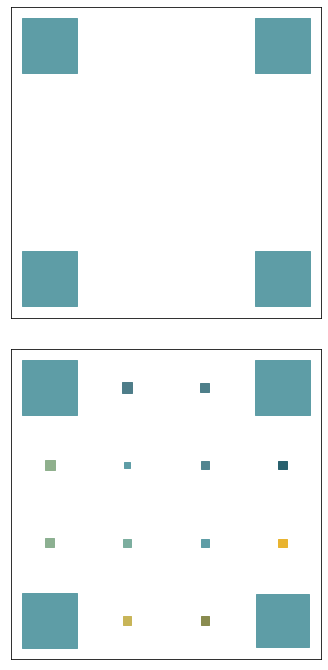

In [13]:
fig_qvm, (ax0_qvm, ax1_qvm) = plt.subplots(2, 1, figsize=(6, 12))
fig_qvm.subplots_adjust(hspace=0.1)
hinton(rho_true, ax=ax0_qvm)
hinton(rho_simulated, ax=ax1_qvm)

In [14]:
print(f"Simulated Bell state fidelity = {np.round(fidelity(rho_true, rho_simulated), 4)*100:.2f}%")

Simulated Bell state fidelity = 97.75%
